# Causal PINN Conceptual Example

### 1. Introduction: The "Arrow of Time" in PINNs

This notebook provides a runnable, conceptual demonstration of a **Causality-Informed PINN**. For time-dependent problems, a standard PINN samples collocation points from the entire spatio-temporal domain at once. This can lead to training instabilities, as the model might try to fit the solution at later times before it has accurately learned the initial behavior, violating the natural "arrow of time" or **causality**.

The **Causal Loss Weighting** strategy addresses this by applying a time-dependent weight to the PDE residual. This weight acts as a curriculum, forcing the optimizer to prioritize minimizing the loss at early times before gradually considering later times.

### 2. Problem Definition: 1D Inviscid Burgers' Equation

We will use the 1D Inviscid Burgers' equation as our test case.
-   **PDE:** $\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$
-   **Domain:** $x \in [-1, 1]$, $t \in [0, 1]$
-   **IC:** $u(x, 0) = -\sin(\pi x)$
-   **BC:** $u(-1, t) = u(1, t) = 0$

The key modification is in the PDE residual function, where we will multiply the standard residual by a causal weight.


In [8]:
import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt


### Step 1: Define the Causal PDE

The implementation of causal weighting in DeepXDE is straightforward. We modify the PDE residual function to include a time-dependent weight.

1.  **Causal Weight Function**: We define a function `causal_weight(x)` that takes the spatial-temporal coordinates `x` and returns a weight. For this example, we use a simple **linear ramp** that increases from 0 at `t=0` to 1 at the final time `T`. More complex functions, like exponentials, are also common.
2.  **Weighted PDE Residual**: We define `pde_causal(x, u)`, which first computes the standard Burgers' equation residual. Then, it multiplies this residual by the output of our `causal_weight` function before returning it.

When DeepXDE computes the loss, it will square this entire weighted output, effectively applying a curriculum that prioritizes early-time data.


In [2]:
# Final time T
T = 1.0

# Causal weight function (linear ramp)
def causal_weight(x):
    t = x[:, 1:2]  # Extract time component
    return t / T

# Causal PDE residual for Burgers' equation
def pde_causal(x, u):
    du_dt = dde.grad.jacobian(u, x, i=0, j=1)
    du_dx = dde.grad.jacobian(u, x, i=0, j=0)
    residual = du_dt + u * du_dx
    
    # Apply the causal weight
    weight = causal_weight(x)
    return weight * residual


### Step 2: Define Geometry, IC, and BCs

Next, we define the problem's geometry and the initial and boundary conditions.

-   **Geometry**: A `TimeDomain` for time `t` and an `Interval` for space `x` are combined into a `GeometryXTime`.
-   **Initial Condition (IC)**: We use `dde.IC` to set `u(x, 0) = -sin(pi*x)`.
-   **Boundary Conditions (BCs)**: Two `dde.DirichletBC` are used to enforce `u(-1, t) = 0` and `u(1, t) = 0`.


In [3]:
# Define the spatio-temporal domain
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define Initial Condition
ic = dde.IC(
    geomtime,
    lambda x: -np.sin(np.pi * x[:, 0:1]),
    lambda _, on_initial: on_initial,
)

# Define Boundary Conditions
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bc_left = dde.DirichletBC(geomtime, lambda x: 0, boundary_left)
bc_right = dde.DirichletBC(geomtime, lambda x: 0, boundary_right)


### Step 3: Set up the PINN Model

Now we assemble the components into a `dde.data.TimePDE` object and define the neural network architecture. We will also create a standard PINN model for comparison to see the effect of causal training.


In [ ]:
# Create the PDE data object for the causal PINN
data_causal = dde.data.TimePDE(
    geomtime,
    pde_causal,
    [ic, bc_left, bc_right],
    num_domain=2500,
    num_initial=100,
    num_boundary=100,
)

# Define the neural networks
net_causal = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

# Create the models
model_causal = dde.Model(data_causal, net_causal)


In [5]:
# Standard PDE for comparison (without causal weight)
def pde_standard(x, u):
    du_dt = dde.grad.jacobian(u, x, i=0, j=1)
    du_dx = dde.grad.jacobian(u, x, i=0, j=0)
    return du_dt + u * du_dx

data_standard = dde.data.TimePDE(
    geomtime,
    pde_standard,
    [ic, bc_left, bc_right],
    num_domain=2500,
    num_initial=100,
    num_boundary=100,
)


# Define the neural networks
net_standard = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

# Create the models
model_standard = dde.Model(data_standard, net_standard)

### Step 4: Train the Models

We train both the causal PINN and the standard PINN. We'll use the Adam optimizer. Note that training PINNs for Burgers' equation can be sensitive; the results can vary.


In [6]:
# Train the Causal PINN
print("--- Training Causal PINN ---")
model_causal.compile("adam", lr=1e-3)
model_causal.train(iterations=15000)

# Train the Standard PINN
print("\n--- Training Standard PINN ---")
model_standard.compile("adam", lr=1e-3)
model_standard.train(iterations=15000)


--- Training Causal PINN ---
Compiling model...
'compile' took 9.884226 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.13e-02, 3.81e-01, 1.73e-02, 2.15e-01]    [4.13e-02, 3.81e-01, 1.73e-02, 2.15e-01]    []  


c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [8.66e-03, 4.65e-04, 1.59e-04, 1.19e-04]    [8.66e-03, 4.65e-04, 1.59e-04, 1.19e-04]    []  
2000      [3.98e-03, 1.25e-04, 2.91e-05, 3.44e-05]    [3.98e-03, 1.25e-04, 2.91e-05, 3.44e-05]    []  
3000      [2.31e-03, 6.54e-05, 1.77e-05, 2.32e-05]    [2.31e-03, 6.54e-05, 1.77e-05, 2.32e-05]    []  
4000      [1.65e-03, 3.92e-05, 1.58e-05, 1.43e-05]    [1.65e-03, 3.92e-05, 1.58e-05, 1.43e-05]    []  
5000      [1.25e-03, 3.31e-05, 1.16e-05, 1.14e-05]    [1.25e-03, 3.31e-05, 1.16e-05, 1.14e-05]    []  
6000      [9.65e-04, 2.08e-05, 2.75e-06, 9.34e-06]    [9.65e-04, 2.08e-05, 2.75e-06, 9.34e-06]    []  
7000      [7.79e-04, 1.50e-05, 5.38e-07, 7.55e-06]    [7.79e-04, 1.50e-05, 5.38e-07, 7.55e-06]    []  
8000      [6.52e-04, 1.11e-05, 4.17e-07, 5.54e-06]    [6.52e-04, 1.11e-05, 4.17e-07, 5.54e-06]    []  
9000      [5.56e-04, 8.32e-06, 3.02e-07, 3.87e-06]    [5.56e-04, 8.32e-06, 3.02e-07, 3.87e-06]    []  
10000     [4.95e-04, 1.27e-04, 5.16e-06, 2.96e-05]    [4.95e-04, 1.27e-04

(<deepxde.model.LossHistory at 0x1f318007550>,
 <deepxde.model.TrainState at 0x1f318007390>)

### Step 5: Visualize and Compare

After training, we can visualize the solutions at different time steps to compare the performance of the causal and standard PINNs. Causal training often leads to a more stable and accurate solution, especially for problems with sharp gradients or shocks like Burgers' equation.


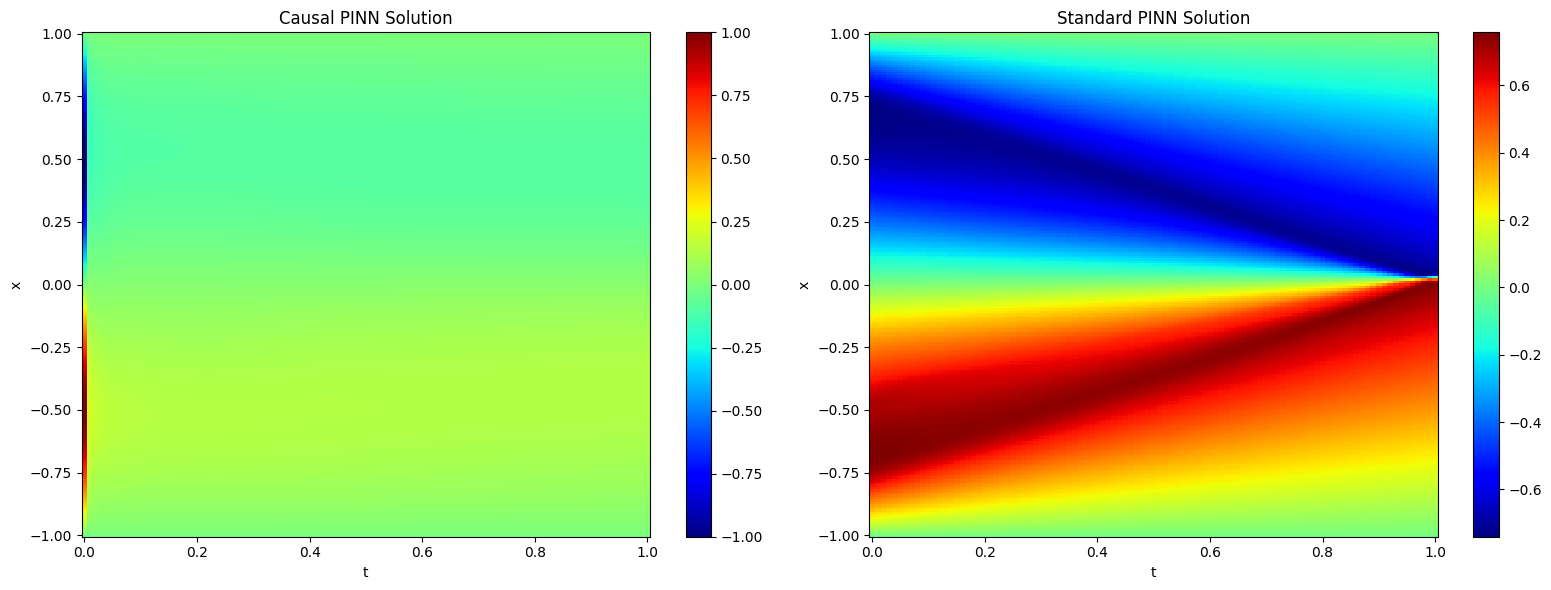

In [9]:
# Create a grid for prediction
x = np.linspace(-1, 1, 201)
t = np.linspace(0, 1, 101)
X, T_grid = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))

# Predict solutions
u_pred_causal = model_causal.predict(X_star).reshape(X.shape)
u_pred_standard = model_standard.predict(X_star).reshape(X.shape)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Causal PINN solution
cax1 = ax1.pcolormesh(T_grid, X, u_pred_causal, cmap='jet')
fig.colorbar(cax1, ax=ax1)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Causal PINN Solution')
ax1.set_aspect('auto')


# Standard PINN solution
cax2 = ax2.pcolormesh(T_grid, X, u_pred_standard, cmap='jet')
fig.colorbar(cax2, ax=ax2)
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Standard PINN Solution')
ax2.set_aspect('auto')


plt.tight_layout()
plt.show()
